<a href="https://colab.research.google.com/github/kaoutar-lakdim/assignment-submissions/blob/main/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports + setup

In [ ]:

!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [ ]:
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as api

# 1. Computing General Statistics

> Ajouter une citation



In [ ]:
df = pd.read_csv('/NikeProductDescriptions.csv')

In [ ]:
# General overview
print(df.shape)
print(df.info())
print(df.describe(include='all'))

(400, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                400 non-null    object
 1   Subtitle             400 non-null    object
 2   Product Description  400 non-null    object
dtypes: object(3)
memory usage: 9.5+ KB
None
                  Title       Subtitle  \
count               400            400   
unique              254            228   
top     Nike Sportswear  Women's Shoes   
freq                 41             34   

                                      Product Description  
count                                                 400  
unique                                                400  
top     It doesn't get more legendary than this. Desig...  
freq                                                    1  


# 2. Filtering data

In [ ]:
keep_subtitles = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes",
    "Skate Shoes", "Older Kids' T-Shirt"
]
df_filtered = df[df['Subtitle'].isin(keep_subtitles) | df['Subtitle'].str.contains('Shorts', na=False)].copy()

# renaming everything containing shorts to shorts
df_filtered.loc[df_filtered['Subtitle'].str.contains('Shorts', na=False), 'Subtitle'] = 'Shorts'

In [ ]:
print(df_filtered.shape)
print(df_filtered.info())
print(df_filtered.describe(include='all'))

(155, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, 0 to 395
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                155 non-null    object
 1   Subtitle             155 non-null    object
 2   Product Description  155 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB
None
                  Title Subtitle  \
count               155      155   
unique              117        6   
top     Nike Sportswear   Shorts   
freq                 13       45   

                                      Product Description  
count                                                 155  
unique                                                155  
top     It doesn't get more legendary than this. Desig...  
freq                                                    1  


In [ ]:
import nltk

# Download required NLTK data files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')   # <— this one fixes your LookupError


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(raw_text):
    words = nltk.word_tokenize(raw_text)
    # strip out non-alpha chars
    words = [re.sub(r'[^a-zA-Z]', '', word) for word in words]
    # lowercase, remove stopwords, stem, and ensure alphabetic
    words = [
        stemmer.stem(word.lower())
        for word in words
        if word.isalpha() and word.lower() not in stop_words
    ]
    return words


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 1. Clean Descriptions using your earlier function
df_filtered['Cleaned_Description'] = df_filtered['Product Description'].apply(lambda x: ' '.join(clean_text(str(x))))

# 2. Load pretrained BERT base model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set model to inference mode

# 3. Function to get mean embedding from BERT last hidden layer
def get_mean_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state  # shape: (1, seq_len, hidden_size)
    return last_hidden_state.squeeze(0).mean(dim=0).numpy()  # mean across tokens

# 4. Compute embeddings for all descriptions
embeddings = np.array([get_mean_bert_embedding(text) for text in tqdm(df_filtered['Cleaned_Description'])])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 155/155 [00:28<00:00,  5.50it/s]


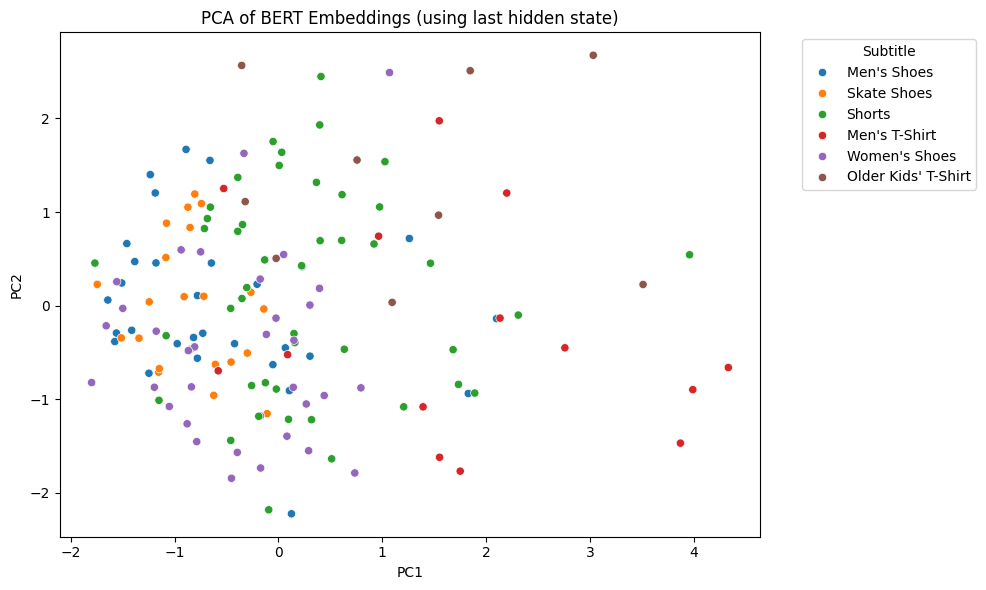

In [ ]:
# 5. Reduce dimensionality with PCA
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embeddings)

# 6. Plot PCA result
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=embedding_pca[:, 0],
    y=embedding_pca[:, 1],
    hue=df_filtered['Subtitle'],
    palette='tab10'
)
plt.title("PCA of BERT Embeddings (using last hidden state)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Subtitle', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

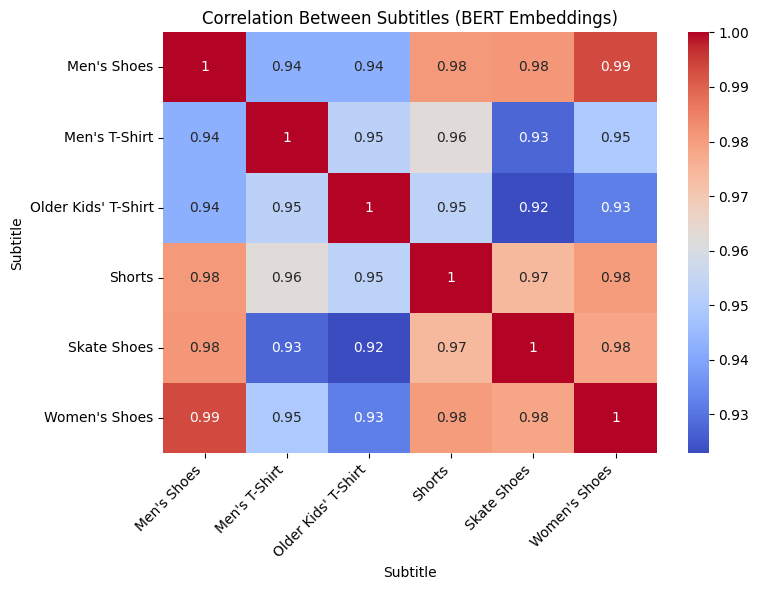

In [ ]:
# 7.1 Create a DataFrame with BERT embeddings and subtitles
embedding_df = pd.DataFrame(embeddings)
embedding_df['Subtitle'] = df_filtered['Subtitle'].values

# 7.2 Group by Subtitle and compute mean embedding per group
grouped_embeddings = embedding_df.groupby('Subtitle').mean()

# 7.3 Compute correlation matrix between subtitle categories
correlation_matrix = grouped_embeddings.T.corr()

# 7.4 Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.index)
plt.title("Correlation Between Subtitles (BERT Embeddings)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
